In [1]:
# transfer of learning for perturbation, using the idea of backprop + hebbian
# need to first find the optimum weight sum when perturbation, otherwise, the loss would shoot up
# it happens that not giving boundary to perturbation period while giving boundary to non-perturbation period produces the best result
# giving boundary might cause convergence to boundary (high loss), for example, when shifts want to jump below 1
# not giving boundary might sink into a local minimum where the loss is really low but gains and shifts are deviant from initial
# may not be generalizable, a better method for narrowing the boundary??
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
from training_abb05_bphebb import SimpleNeuralNetwork
from tqdm.notebook import tqdm

In [2]:
# load the pickle file
with open('weights_abb05_bphebb.pkl', 'rb') as f:
    model_rep = pickle.load(f)

In [3]:
# input and target
ndata = 200
xs = torch.linspace(0, 2 * torch.pi, ndata)
ys = torch.cos(xs)/4 + 0.5

In [8]:
# bp on weight to find the hebb alpha for perturbed network
# init
input_size = 230
init_gain = 3 * np.ones((input_size, 1))
init_shift = 1 * np.ones((input_size, 1))
init_weight = np.ones((1, input_size)) * 5.5 / input_size

# Training Loop
weight_epochs = 200
backprop_lr = 0.01

# define noise
np.random.seed(42)
W = np.eye(input_size) * 0.001
x_noises = (np.random.multivariate_normal(mean=np.zeros(input_size), cov=W, size=weight_epochs)).T * 0
x_noises = torch.tensor(x_noises, dtype=torch.float32)
x_noises += 0.1

# record
weight_losses = []
weight_sums = []
# weights = []

for epoch in tqdm(range(weight_epochs), position=0, leave=True):
    
    # establish model
    model = SimpleNeuralNetwork(input_size, init_gain, init_shift, init_weight)

    # shuffle data
    perm_idx = torch.randperm(ndata)
    shuffled_xs = xs[perm_idx]
    shuffled_ys = ys[perm_idx]
    epoch_loss = 0

    # go through all data
    for x, y in zip(shuffled_xs, shuffled_ys):  
        # forward
        inpu_ipl = model.gaussian_rf(x)
        actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift)) + (x_noises[:, epoch]).reshape(-1, 1)
        # actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift))
        model.input_activation = actv_ipl.clone()
        inpu_opl = torch.matmul(model.weights, actv_ipl)
        actv_opl = model.activation_func(model.gainout * (inpu_opl - model.shiftout))
        model.output_activation = actv_opl.clone()          
        output = actv_opl.squeeze()
        # Calculate loss
        loss_func = nn.MSELoss()
        loss = 0.5 * loss_func(output, y)
        
        # backprop
        optimizer = optim.SGD([model.weights], lr=backprop_lr)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()

    # update init
    init_gain = model.gain.detach().numpy()
    init_shift = model.shift.detach().numpy()
    init_weight = model.weights.detach().numpy()

    # record
    epoch_loss /= ndata
    weight_losses.append(epoch_loss)
    weight_sums.append(np.sum(init_weight))

    # print out info
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}/{weight_epochs}, Loss: {epoch_loss}, Sum: {np.sum(init_weight)}')


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200, Loss: 0.007940478413878254, Sum: 3.6020607948303223
Epoch 11/200, Loss: 4.5484145409391276e-07, Sum: 3.6033477783203125
Epoch 21/200, Loss: 5.2756838586631714e-08, Sum: 3.6030385494232178
Epoch 31/200, Loss: 2.7203570278633293e-08, Sum: 3.603201389312744
Epoch 41/200, Loss: 2.6464547049354082e-08, Sum: 3.603036403656006
Epoch 51/200, Loss: 2.8001637588648265e-08, Sum: 3.603346347808838
Epoch 61/200, Loss: 2.6008581328618165e-08, Sum: 3.602891683578491
Epoch 71/200, Loss: 2.617448578767778e-08, Sum: 3.6030142307281494
Epoch 81/200, Loss: 2.646586403143303e-08, Sum: 3.6032960414886475
Epoch 91/200, Loss: 2.675655679018618e-08, Sum: 3.603313446044922
Epoch 101/200, Loss: 2.493494401178964e-08, Sum: 3.603369951248169
Epoch 111/200, Loss: 2.510593192228683e-08, Sum: 3.603349447250366
Epoch 121/200, Loss: 2.5371892624637127e-08, Sum: 3.6029200553894043
Epoch 131/200, Loss: 2.6160823600740457e-08, Sum: 3.602788209915161
Epoch 141/200, Loss: 2.2406712845146616e-08, Sum: 3.60308218

### The Function for Perturbation Analysis

In [32]:
class PerturbNetwork():
     
    def __init__(self, model_rep, simu_epochs=1500, perturb_start=50, perturb_last=500, perturb_amp=0.1, only_backprop_epoch=10,
                 backprop_lr=0.2, hebbian_lr=0.0001, hebb_alpha=5.5):
        # init params
        self.simu_epochs = simu_epochs
        self.perturb_start = perturb_start
        self.perturb_last = perturb_last
        self.perturb_amp = perturb_amp
        self.only_backprop_epoch = only_backprop_epoch
        self.backprop_lr = backprop_lr
        self.hebbian_lr = hebbian_lr
        self.hebb_alpha = hebb_alpha

        # some hard defined params
        self.input_size = 230
        self.theo_gain = 3 * np.ones((self.input_size, 1))
        self.theo_shift = 1 * np.ones((self.input_size, 1))

        # init models
        self.init_gain = model_rep.gain.detach().numpy()
        self.init_shift = model_rep.shift.detach().numpy()
        self.init_weight = model_rep.weights.detach().numpy()

    def simulate(self, ndata=200):
        # set seed
        np.random.seed(42)
        torch.manual_seed(42)

        # data prep
        xs = torch.linspace(0, 2 * torch.pi, ndata)
        ys = torch.cos(xs)/4 + 0.5
    
        # define noise
        W = np.eye(self.input_size) * 0.001
        x_noises = (np.random.multivariate_normal(mean=np.zeros(self.input_size), cov=W, size=self.simu_epochs)).T * 0
        x_noises = torch.tensor(x_noises, dtype=torch.float32)
        x_noises[:,self.perturb_start:self.perturb_start+self.perturb_last] += self.perturb_amp

        # flags
        has_backprop = True  # always true
        has_boundary = False
        has_hebbian = True
        has_perturb = False

        # to record
        simu_losses = []
        gain_changes = []
        shift_changes = []
        weight_sums = []
        epoch_loss = 0

        for epoch in tqdm(range(self.simu_epochs)):
            if epoch == self.perturb_start:
                has_perturb = True
                has_hebbian = False
                has_boundary = False
                # hebbian_lr = 0
                print("perturbation start!!!")
            if epoch == self.perturb_start + self.perturb_last:
                has_perturb = False
                has_hebbian = False
                has_boundary = False
                # hebbian_lr = 0
                print("perturbation end!!!")

            # shuffle data
            ndata = len(xs)
            perm_idx = torch.randperm(ndata)
            shuffled_xs = xs[perm_idx]
            shuffled_ys = ys[perm_idx]
            last_epoch_loss = epoch_loss
            epoch_loss = 0

            # start hebbian and shrinkage
            if has_perturb and epoch > self.perturb_start + self.only_backprop_epoch and last_epoch_loss < 0.001 and has_hebbian == False:
                has_hebbian = True
                print("perturb learning start!!!")
            if not has_perturb and epoch > self.perturb_start + self.perturb_last + self.only_backprop_epoch and last_epoch_loss < 0.001 and has_hebbian == False:
                has_hebbian = True
                print("origin learning start!!!")
            # if has_perturb and epoch > perturb_start + 10 and last_epoch_loss < 0.001 and has_boundary == False:
            #     gain_ub = np.maximum(init_gain, theo_gain) + 0.1
            #     gain_lb = np.minimum(init_gain, theo_gain) - 0.1
            #     shift_ub = np.maximum(init_shift, theo_shift) + 0.1
            #     shift_lb = np.minimum(init_shift, theo_shift) - 0.1
            #     has_boundary = True
            #     print("perturb boundary created!!!")
            if not has_perturb and epoch > self.perturb_start + self.perturb_last + self.only_backprop_epoch and last_epoch_loss < 0.001 and has_boundary == False:
                gain_ub = np.maximum(self.init_gain, self.theo_gain)
                gain_lb = np.minimum(self.init_gain, self.theo_gain)
                shift_ub = np.maximum(self.init_shift, self.theo_shift)
                shift_lb = np.minimum(self.init_shift, self.theo_shift)
                has_boundary = True
                print("origin boundary created!!!")
                
            # # update hebbian learning rate, once per epoch
            # if has_hebbian and hebbian_lr < max_hebbian_lr:
            #     hebbian_lr += hebbian_up_rate
            
            # go through all data
            for x, y in zip(shuffled_xs, shuffled_ys):  
                # establish model
                model = SimpleNeuralNetwork(self.input_size, self.init_gain, self.init_shift, self.init_weight)
                # forward
                inpu_ipl = model.gaussian_rf(x)
                actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift)) + (x_noises[:, epoch]).reshape(-1, 1)
                model.input_activation = actv_ipl.clone()
                inpu_opl = torch.matmul(model.weights, actv_ipl)
                actv_opl = model.activation_func(model.gainout * (inpu_opl - model.shiftout))
                model.output_activation = actv_opl.clone()          
                output = actv_opl.squeeze()
                # Calculate loss
                loss_func = nn.MSELoss()
                loss = 0.5 * loss_func(output, y)
                epoch_loss += loss

                # backprop for gains and shifts
                if has_backprop:
                    optimizer = optim.SGD([model.gain, model.shift], lr=self.backprop_lr)
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()
                # update init gains and shifts
                self.init_gain = model.gain.detach().numpy()
                self.init_shift = model.shift.detach().numpy()
                gain_change = np.linalg.norm(self.init_gain - self.theo_gain, 2)
                shift_change = np.linalg.norm(self.init_shift - self.theo_shift, 2)

                # hebbian learning for weights
                if has_hebbian:
                    # Calculate Hebbian weight updates
                    hebbian_update = model.output_activation * (model.input_activation).T
                    # Apply Hebbian updates and normalize
                    model.weights = model.weights + self.hebbian_lr * hebbian_update
                    model.weights = model.weights / torch.sum(model.weights) * self.hebb_alpha
                # update init weights
                self.init_weight = model.weights.detach().numpy()

                # shrink shift and gain to init value
                if has_boundary:
                    # passively narrow the boundaries
                    # if gain_change > 0.1:
                    gain_ub = np.maximum(np.minimum(self.init_gain, gain_ub), self.theo_gain)
                    gain_lb = np.minimum(np.maximum(self.init_gain, gain_lb), self.theo_gain)
                    # if shift_change > 0.1:
                    shift_ub = np.maximum(np.minimum(self.init_shift, shift_ub), self.theo_shift)
                    shift_lb = np.minimum(np.maximum(self.init_shift, shift_lb), self.theo_shift)
                    # pull gains and shifts back to into boundaries
                    self.init_gain = np.minimum(self.init_gain, gain_ub)
                    self.init_gain = np.maximum(self.init_gain, gain_lb)
                    self.init_shift = np.minimum(self.init_shift, shift_ub)
                    self.init_shift = np.maximum(self.init_shift, shift_lb)

            # print losses
            epoch_loss /= ndata
            if epoch % 10 == 0:
                print(f"Epoch: {epoch}, Loss: {epoch_loss}")

            # if epoch > 1000 and self.backprop_lr > 0.01:
            #     self.backprop_lr -= 0.01
            
            # record
            simu_losses.append(epoch_loss.item())
            weight_sums.append(np.sum(self.init_weight))
            gain_changes.append(gain_change)
            shift_changes.append(shift_change)

        return simu_losses, weight_sums, gain_changes, shift_changes, model

### Perturbation 500 Epochs

problem now: when stop perturbation, the network can't return to intial gains and shifts??

In [35]:
simulator = PerturbNetwork(model_rep)
simu_losses, weight_sums, gain_changes, shift_changes, model = simulator.simulate(ndata=200)

  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch: 0, Loss: 4.8120800784090534e-05
Epoch: 10, Loss: 9.723786206450313e-06
Epoch: 20, Loss: 7.06755736246123e-06
Epoch: 30, Loss: 6.709870831400622e-06
Epoch: 40, Loss: 6.48375407763524e-06
perturbation start!!!
Epoch: 50, Loss: 0.11529789865016937
Epoch: 60, Loss: 0.0003984993672929704
perturb learning start!!!
Epoch: 70, Loss: 0.00013361511810217053
Epoch: 80, Loss: 7.821749022696167e-05
Epoch: 90, Loss: 4.626146983355284e-05
Epoch: 100, Loss: 2.604028668429237e-05
Epoch: 110, Loss: 1.636544220673386e-05
Epoch: 120, Loss: 1.2134547432651743e-05
Epoch: 130, Loss: 1.0066678441944532e-05
Epoch: 140, Loss: 8.921425433072727e-06
Epoch: 150, Loss: 8.242268449976109e-06
Epoch: 160, Loss: 8.088011782092508e-06
Epoch: 170, Loss: 7.286796517291805e-06
Epoch: 180, Loss: 6.7218875301477965e-06
Epoch: 190, Loss: 6.3925863287295215e-06
Epoch: 200, Loss: 5.742629127780674e-06
Epoch: 210, Loss: 5.516359124158043e-06
Epoch: 220, Loss: 5.086822056910023e-06
Epoch: 230, Loss: 4.6554077925975434e-06


In [95]:
# # perturbation for 2000 epochs
# simu_epochs = 4000
# perturb_start = 50
# perturb_last = 2000
# input_size = 230
# theo_gain = 3 * np.ones((input_size, 1))
# theo_shift = 1 * np.ones((input_size, 1))
# init_gain = model_rep.gain.detach().numpy()
# init_shift = model_rep.shift.detach().numpy()
# init_weight = model_rep.weights.detach().numpy()
# hebbian_lr = 0.0001
# max_hebbian_lr = 0.0001
# hebbian_up_rate = max_hebbian_lr / 100
# hebb_alpha = 5.5
# hebb_alpha_origin = 5.5
# hebb_alpha_perturb = 5.5  # 3.5
# hebb_alpha_up_rate = (hebb_alpha_perturb - hebb_alpha) / 100
# backprop_lr = 0.2
# has_backprop = True
# has_boundary = False
# has_hebbian = True
# has_perturb = False

# # define noise
# np.random.seed(42)
# W = np.eye(input_size) * 0.001
# x_noises = (np.random.multivariate_normal(mean=np.zeros(input_size), cov=W, size=simu_epochs)).T * 0
# x_noises = torch.tensor(x_noises, dtype=torch.float32)
# x_noises[:,perturb_start:perturb_start+perturb_last] += 0.1

# simu_losses = []
# gain_changes = []
# shift_changes = []
# weight_sums = []
# epoch_loss = 0

# for epoch in tqdm(range(simu_epochs), position=0, leave=True):
#     if epoch == perturb_start:
#         has_perturb = True
#         has_hebbian = False
#         has_boundary = False
#         hebbian_lr = 0
#         print("perturbation start!!!")
#     if epoch == perturb_start + perturb_last:
#         has_perturb = False
#         has_hebbian = False
#         has_boundary = False
#         hebbian_lr = 0
#         print("perturbation end!!!")
   
#     # shuffle data
#     perm_idx = torch.randperm(ndata)
#     shuffled_xs = xs[perm_idx]
#     shuffled_ys = ys[perm_idx]
#     last_epoch_loss = epoch_loss
#     epoch_loss = 0

#     # start hebbian and shrinkage
#     if has_perturb and epoch > perturb_start + 10 and last_epoch_loss < 0.001 and has_hebbian == False:
#         has_hebbian = True
#         print("perturb learning start!!!")
#     if not has_perturb and epoch > perturb_start + perturb_last + 10 and last_epoch_loss < 0.001 and has_hebbian == False:
#         has_hebbian = True
#         print("origin learning start!!!")
#     # if has_perturb and epoch > perturb_start + 10 and last_epoch_loss < 0.001 and has_boundary == False:
#     #     gain_ub = np.maximum(init_gain, theo_gain) + 0.1
#     #     gain_lb = np.minimum(init_gain, theo_gain) - 0.1
#     #     shift_ub = np.maximum(init_shift, theo_shift) + 0.1
#     #     shift_lb = np.minimum(init_shift, theo_shift) - 0.1
#     #     has_boundary = True
#     #     print("perturb boundary created!!!")
#     if not has_perturb and epoch > perturb_start + perturb_last + 10 and last_epoch_loss < 0.001 and has_boundary == False:
#         gain_ub = np.maximum(init_gain, theo_gain)
#         gain_lb = np.minimum(init_gain, theo_gain)
#         shift_ub = np.maximum(init_shift, theo_shift)
#         shift_lb = np.minimum(init_shift, theo_shift)
#         has_boundary = True
#         print("origin boundary created!!!")
        
#     # update hebbian learning rate, once per epoch
#     if has_hebbian and hebbian_lr < max_hebbian_lr:
#         hebbian_lr += hebbian_up_rate
#     if has_hebbian and has_perturb and hebb_alpha > hebb_alpha_perturb:
#         hebb_alpha += hebb_alpha_up_rate
#     if has_hebbian and not has_perturb and hebb_alpha < hebb_alpha_origin:
#         hebb_alpha -= hebb_alpha_up_rate
    
#     # go through all data
#     for x, y in zip(shuffled_xs, shuffled_ys):  
#         # establish model
#         model = SimpleNeuralNetwork(input_size, init_gain, init_shift, init_weight)
#         # forward
#         inpu_ipl = model.gaussian_rf(x)
#         actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift)) + (x_noises[:, epoch]).reshape(-1, 1)
#         # actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift))
#         model.input_activation = actv_ipl.clone()
#         inpu_opl = torch.matmul(model.weights, actv_ipl)
#         actv_opl = model.activation_func(model.gainout * (inpu_opl - model.shiftout))
#         model.output_activation = actv_opl.clone()          
#         output = actv_opl.squeeze()
#         # Calculate loss
#         loss_func = nn.MSELoss()
#         loss = 0.5 * loss_func(output, y)
#         epoch_loss += loss

#         # backprop for gains and shifts
#         if has_backprop:
#             optimizer = optim.SGD([model.gain, model.shift], lr=backprop_lr)
#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()
#         # update init gains and shifts
#         init_gain = model.gain.detach().numpy()
#         init_shift = model.shift.detach().numpy()
#         gain_change = np.linalg.norm(init_gain - theo_gain, 2)
#         shift_change = np.linalg.norm(init_shift - theo_shift, 2)

#         # hebbian learning for weights
#         if has_hebbian:
#             # Calculate Hebbian weight updates
#             hebbian_update = model.output_activation * (model.input_activation).T
#             # Apply Hebbian updates and normalize
#             model.weights = model.weights + hebbian_lr * hebbian_update
#             model.weights = model.weights / torch.sum(model.weights) * hebb_alpha
#         # update init weights
#         init_weight = model.weights.detach().numpy()

#         # shrink shift and gain to init value
#         if has_boundary:
#             # passively narrow the boundaries
#             # gain_ub = np.maximum(np.minimum(init_gain, gain_ub), theo_gain)
#             # gain_lb = np.minimum(np.maximum(init_gain, gain_lb), theo_gain)
#             # shift_ub = np.maximum(np.minimum(init_shift, shift_ub), theo_shift)
#             # shift_lb = np.minimum(np.maximum(init_shift, shift_lb), theo_shift)
#             # pull gains and shifts back to into boundaries
#             init_gain = np.minimum(init_gain, gain_ub)
#             init_gain = np.maximum(init_gain, gain_lb)
#             init_shift = np.minimum(init_shift, shift_ub)
#             init_shift = np.maximum(init_shift, shift_lb)

#     # print losses
#     epoch_loss /= ndata
#     if epoch % 20 == 0:
#         print(f"Epoch: {epoch}, Loss: {epoch_loss}")
#         # print(f"Gains: {init_gain[0:10].flatten()}")
#         # print(f"Shifts: {init_shift[0:10].flatten()}")

#     # record
#     simu_losses.append(epoch_loss.item())
#     weight_sums.append(np.sum(init_weight))
#     gain_changes.append(gain_change)
#     shift_changes.append(shift_change)

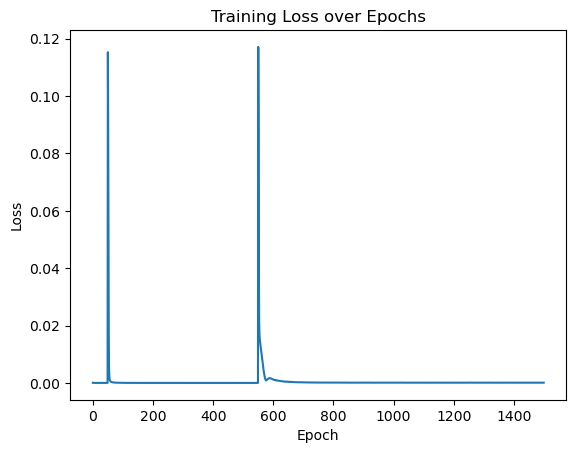

In [37]:
# Plotting the loss
plt.plot(range(len(simu_losses)), simu_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0,0.01])
plt.title('Training Loss over Epochs')
# plt.savefig('abb05_loss.png')
plt.show()

In [38]:
# input and target
ndata = 200
xs = torch.linspace(0, 2 * torch.pi, ndata)
ys = torch.cos(xs)/4 + 0.5

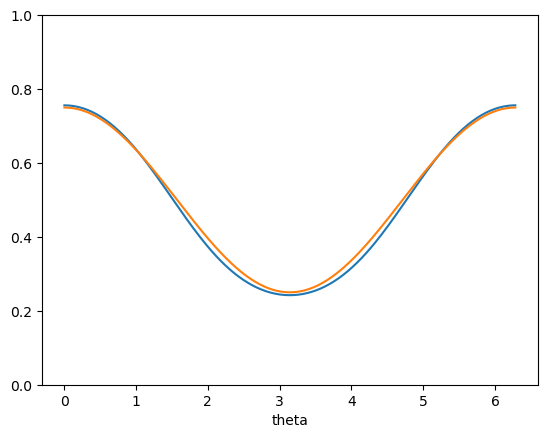

In [39]:
# Plotting the outputs
model.eval()
outputs = []
for x in xs:
    output = model(x)
    outputs.append(output.item())
plt.plot(xs, outputs)
plt.plot(xs, ys, label='target')
plt.ylim([0,1])
plt.xlabel("theta")
# plt.savefig('abb05_outputs.png')
plt.show()

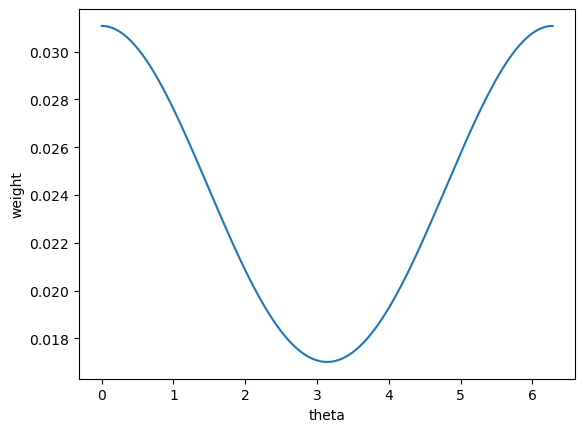

In [40]:
final_weight = model.weights.detach().numpy()
plt.plot(np.linspace(0, 2 * np.pi, model.input_size), final_weight.flatten())
# plt.ylim([0,8])
plt.xlabel("theta")
plt.ylabel("weight")
# plt.savefig('abb05_ws.png')
plt.show()

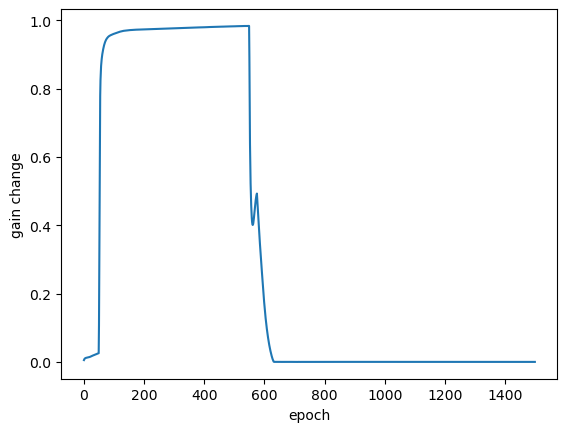

In [41]:
plt.plot(np.arange(len(simu_losses)), gain_changes)
plt.xlabel("epoch")
plt.ylabel("gain change")
# plt.hlines(y=np.sqrt(460)*0.1, xmin=0, xmax=epochs)
# plt.savefig('abb05_gc.png')
plt.show()

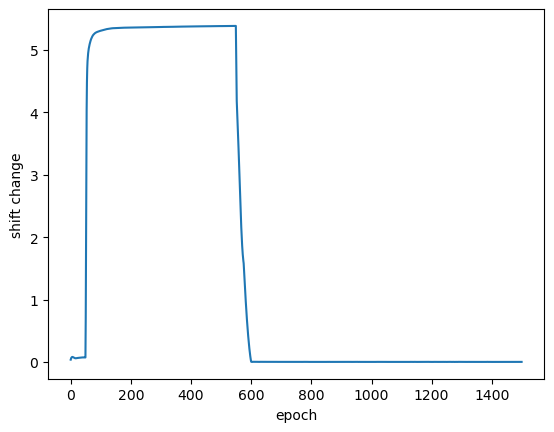

In [42]:
plt.plot(np.arange(len(simu_losses)), shift_changes)
plt.xlabel("epoch")
plt.ylabel("shift change")
# plt.hlines(y=np.sqrt(460)*0.1, xmin=0, xmax=epochs)
# plt.savefig('abb05_sc.png')
plt.show()

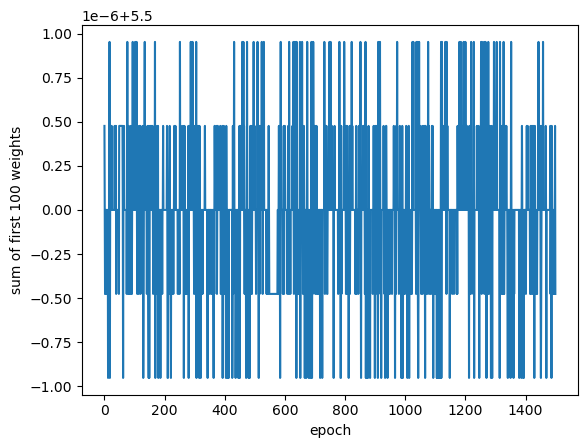

In [43]:
plt.plot(np.arange(len(simu_losses)), weight_sums)
# plt.ylim([0,8])
plt.xlabel("epoch")
plt.ylabel("sum of first 100 weights")
# plt.savefig('abb05_ws.png')
plt.show()

In [44]:
rates = []
for x in xs:
    input = model.gaussian_rf(x)
    rate = model.activation_func(model.gain * (input - model.shift))
    rates.append(rate)
rates = torch.cat(rates, dim=1)
rates = rates.detach().numpy().round(4)
rates

array([[0.5   , 0.4997, 0.4985, ..., 0.4985, 0.4997, 0.5   ],
       [0.4997, 0.5   , 0.4995, ..., 0.497 , 0.4987, 0.4997],
       [0.4989, 0.4998, 0.5   , ..., 0.4948, 0.4972, 0.4989],
       ...,
       [0.4989, 0.4972, 0.4948, ..., 0.5   , 0.4998, 0.4989],
       [0.4997, 0.4987, 0.497 , ..., 0.4996, 0.5   , 0.4997],
       [0.5   , 0.4997, 0.4985, ..., 0.4985, 0.4997, 0.5   ]],
      dtype=float32)

Text(0, 0.5, 'firing rate')

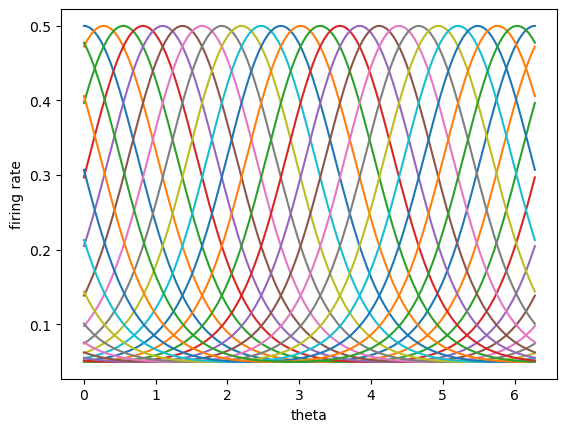

In [45]:
for i in np.arange(0,model.input_size,10):
    thisr = rates[i,:]
    plt.plot(xs, thisr)
plt.xlabel("theta")
plt.ylabel("firing rate")
# plt.savefig('abb05_rf.png')

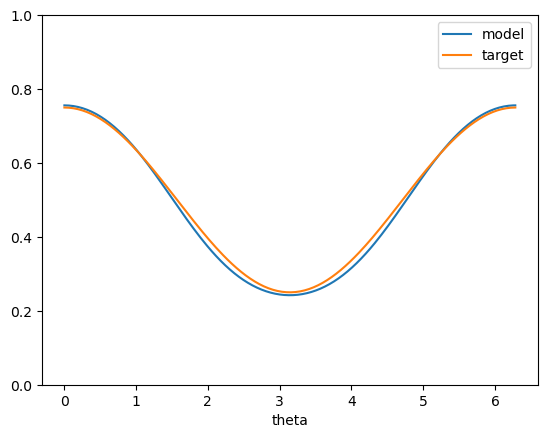

In [46]:
# Plotting the outputs
model.gain = model.init_gain
model.shift = model.init_shift
model.eval()
outputs = []
for x in xs:
    output = model(x)
    outputs.append(output.item())
plt.plot(xs, outputs, label='model')
plt.plot(xs, ys, label='target')
plt.ylim([0,1])
plt.xlabel("theta")
plt.legend()
# plt.savefig('abb05_outputs_nosup.png')

### Different Perturbation Lasts

In [ ]:
# # manual simulation
# perturb_lasts = [1000, 2000, 5000]

# all_simu_losses = []
# all_gain_changes = []
# all_shift_changes = []
# all_weight_sums = []

# for perturb_last in perturb_lasts:

#     print(f"perturb_last: {perturb_last}")

#     simu_epochs = 8000
#     perturb_start = 50
#     # perturb_last = 500
#     input_size = 230
#     theo_gain = 3 * np.ones((input_size, 1))
#     theo_shift = 1 * np.ones((input_size, 1))
#     init_gain = model_rep.gain.detach().numpy()
#     init_shift = model_rep.shift.detach().numpy()
#     init_weight = model_rep.weights.detach().numpy()
#     hebbian_lr = 0.0001
#     max_hebbian_lr = 0.0001
#     hebbian_up_rate = max_hebbian_lr / 100
#     hebb_alpha = 5.5
#     hebb_alpha_origin = 5.5
#     hebb_alpha_perturb = 5.5
#     hebb_alpha_up_rate = (hebb_alpha_perturb - hebb_alpha) / 100
#     backprop_lr = 0.2
#     has_backprop = True
#     has_boundary = False
#     has_hebbian = True
#     has_perturb = False

#     # define noise
#     np.random.seed(42)
#     W = np.eye(input_size) * 0.001
#     x_noises = (np.random.multivariate_normal(mean=np.zeros(input_size), cov=W, size=simu_epochs)).T * 0
#     x_noises = torch.tensor(x_noises, dtype=torch.float32)
#     x_noises[:,perturb_start:perturb_start+perturb_last] += 0.1

#     simu_losses = []
#     gain_changes = []
#     shift_changes = []
#     weight_sums = []
#     epoch_loss = 0

#     for epoch in tqdm(range(simu_epochs), position=0, leave=True):
#         if epoch == perturb_start:
#             has_perturb = True
#             has_hebbian = False
#             has_boundary = False
#             hebbian_lr = 0
#             print("perturbation start!!!")
#         if epoch == perturb_start + perturb_last:
#             has_perturb = False
#             has_hebbian = False
#             has_boundary = False
#             hebbian_lr = 0
#             print("perturbation end!!!")
        
#         # shuffle data
#         perm_idx = torch.randperm(ndata)
#         shuffled_xs = xs[perm_idx]
#         shuffled_ys = ys[perm_idx]
#         last_epoch_loss = epoch_loss
#         epoch_loss = 0

#         # start hebbian and shrinkage
#         if has_perturb and epoch > perturb_start + 10 and last_epoch_loss < 0.001 and has_hebbian == False:
#             has_hebbian = True
#             print("perturb learning start!!!")
#         if not has_perturb and epoch > perturb_start + perturb_last + 10 and last_epoch_loss < 0.001 and has_hebbian == False:
#             has_hebbian = True
#             print("origin learning start!!!")
#         # if has_perturb and epoch > perturb_start + 10 and last_epoch_loss < 0.001 and has_boundary == False:
#         #     gain_ub = np.maximum(init_gain, theo_gain)
#         #     gain_lb = np.minimum(init_gain, theo_gain)
#         #     shift_ub = np.maximum(init_shift, theo_shift)
#         #     shift_lb = np.minimum(init_shift, theo_shift)
#         #     has_boundary = True
#         #     print("perturb boundary created!!!")
#         if not has_perturb and epoch > perturb_start + perturb_last + 10 and last_epoch_loss < 0.001 and has_boundary == False:
#             gain_ub = np.maximum(init_gain, theo_gain)
#             gain_lb = np.minimum(init_gain, theo_gain)
#             shift_ub = np.maximum(init_shift, theo_shift)
#             shift_lb = np.minimum(init_shift, theo_shift)
#             has_boundary = True
#             print("origin boundary created!!!")
     
#         # update hebbian learning rate, once per epoch
#         if has_hebbian and hebbian_lr < max_hebbian_lr:
#             hebbian_lr += hebbian_up_rate
#         if has_hebbian and has_perturb and hebb_alpha > hebb_alpha_perturb:
#             hebb_alpha += hebb_alpha_up_rate
#         if has_hebbian and not has_perturb and hebb_alpha < hebb_alpha_origin:
#             hebb_alpha -= hebb_alpha_up_rate
        
#         # go through all data
#         for x, y in zip(shuffled_xs, shuffled_ys):  
#             # establish model
#             model = SimpleNeuralNetwork(input_size, init_gain, init_shift, init_weight)
#             # forward
#             inpu_ipl = model.gaussian_rf(x)
#             actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift)) + (x_noises[:, epoch]).reshape(-1, 1)
#             # actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift))
#             model.input_activation = actv_ipl.clone()
#             inpu_opl = torch.matmul(model.weights, actv_ipl)
#             actv_opl = model.activation_func(model.gainout * (inpu_opl - model.shiftout))
#             model.output_activation = actv_opl.clone()          
#             output = actv_opl.squeeze()
#             # Calculate loss
#             loss_func = nn.MSELoss()
#             loss = 0.5 * loss_func(output, y)
#             epoch_loss += loss

#             # backprop for gains and shifts
#             if has_backprop:
#                 optimizer = optim.SGD([model.gain, model.shift], lr=backprop_lr)
#                 loss.backward()
#                 optimizer.step()
#                 optimizer.zero_grad()
#             # update init gains and shifts
#             init_gain = model.gain.detach().numpy()
#             init_shift = model.shift.detach().numpy()
#             gain_change = np.linalg.norm(init_gain - theo_gain, 2)
#             shift_change = np.linalg.norm(init_shift - theo_shift, 2)

#             # hebbian learning for weights
#             if has_hebbian:
#                 # Calculate Hebbian weight updates
#                 hebbian_update = model.output_activation * (model.input_activation).T
#                 # Apply Hebbian updates and normalize
#                 model.weights = model.weights + hebbian_lr * hebbian_update
#                 model.weights = model.weights / torch.sum(model.weights) * hebb_alpha
#             # update init weights
#             init_weight = model.weights.detach().numpy()

#             # shrink shift and gain to init value
#             if has_boundary:
#                 # passively narrow the boundaries
#                 # gain_ub = np.maximum(np.minimum(init_gain, gain_ub), theo_gain)
#                 # gain_lb = np.minimum(np.maximum(init_gain, gain_lb), theo_gain)
#                 # shift_ub = np.maximum(np.minimum(init_shift, shift_ub), theo_shift)
#                 # shift_lb = np.minimum(np.maximum(init_shift, shift_lb), theo_shift)
#                 # pull gains and shifts back to into boundaries
#                 init_gain = np.minimum(init_gain, gain_ub)
#                 init_gain = np.maximum(init_gain, gain_lb)
#                 init_shift = np.minimum(init_shift, shift_ub)
#                 init_shift = np.maximum(init_shift, shift_lb)

#         # print losses
#         epoch_loss /= ndata
#         if epoch % 100 == 0:
#             print(f"Epoch: {epoch}, Loss: {epoch_loss}")

#         # record
#         simu_losses.append(epoch_loss.item())
#         weight_sums.append(np.sum(init_weight))
#         gain_changes.append(gain_change)
#         shift_changes.append(shift_change)
    
#     # record
#     all_simu_losses.append(simu_losses)
#     all_gain_changes.append(gain_changes)
#     all_shift_changes.append(shift_changes)
#     all_weight_sums.append(weight_sums)

In [47]:
# systematic perturbation tests
perturb_lasts_exp = np.arange(1,3.3,0.2)
perturb_lasts = np.power(10, perturb_lasts_exp).astype(int)

# to record
all_simu_losses = []
all_gain_changes = []
all_shift_changes = []
all_weight_sums = []
simu_epochs = 2000

for perturb_last in perturb_lasts:
    simulator = PerturbNetwork(model_rep, simu_epochs=simu_epochs, perturb_last=perturb_last)
    simu_losses, weight_sums, gain_changes, shift_changes, model = simulator.simulate(ndata=200)
    all_simu_losses.append(simu_losses)
    all_gain_changes.append(gain_changes)
    all_shift_changes.append(shift_changes)
    all_weight_sums.append(weight_sums)

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0, Loss: 4.8120800784090534e-05
Epoch: 10, Loss: 9.723786206450313e-06
Epoch: 20, Loss: 7.06755736246123e-06
Epoch: 30, Loss: 6.709870831400622e-06
Epoch: 40, Loss: 6.48375407763524e-06
perturbation start!!!
Epoch: 50, Loss: 0.11529789865016937
perturbation end!!!
Epoch: 60, Loss: 0.11884456872940063
Epoch: 70, Loss: 0.007758790627121925
Epoch: 80, Loss: 0.0007695478852838278
origin learning start!!!
origin boundary created!!!
Epoch: 90, Loss: 0.0001654569205129519
Epoch: 100, Loss: 0.00013597500219475478
Epoch: 110, Loss: 0.0001442114298697561
Epoch: 120, Loss: 0.00011453854676801711
Epoch: 130, Loss: 0.00010945228859782219
Epoch: 140, Loss: 0.00010559099609963596
Epoch: 150, Loss: 0.00011160174472024664
Epoch: 160, Loss: 0.00010750576620921493
Epoch: 170, Loss: 9.73553687799722e-05
Epoch: 180, Loss: 9.555902943247929e-05
Epoch: 190, Loss: 0.00010684508015401661
Epoch: 200, Loss: 0.00010329997894586995
Epoch: 210, Loss: 9.965262142941356e-05
Epoch: 220, Loss: 9.952070831786841e

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0, Loss: 4.8120800784090534e-05
Epoch: 10, Loss: 9.723786206450313e-06
Epoch: 20, Loss: 7.06755736246123e-06
Epoch: 30, Loss: 6.709870831400622e-06
Epoch: 40, Loss: 6.48375407763524e-06
perturbation start!!!
Epoch: 50, Loss: 0.11529789865016937
Epoch: 60, Loss: 0.0003984993672929704
perturb learning start!!!
perturbation end!!!
Epoch: 70, Loss: 0.014056389220058918
Epoch: 80, Loss: 0.0043422463349998
origin learning start!!!
origin boundary created!!!
Epoch: 90, Loss: 0.00042863708222284913
Epoch: 100, Loss: 0.00015137372247409075
Epoch: 110, Loss: 0.00015936317504383624
Epoch: 120, Loss: 0.00012531135871540755
Epoch: 130, Loss: 0.00011697057925630361
Epoch: 140, Loss: 0.00011064019054174423
Epoch: 150, Loss: 0.00011516186350490898
Epoch: 160, Loss: 0.00010953455057460815
Epoch: 170, Loss: 9.793519711820409e-05
Epoch: 180, Loss: 9.524951019557193e-05
Epoch: 190, Loss: 0.00010608079173834994
Epoch: 200, Loss: 0.00010186822328250855
Epoch: 210, Loss: 9.758940723259002e-05
Epoch: 2

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0, Loss: 4.8120800784090534e-05
Epoch: 10, Loss: 9.723786206450313e-06
Epoch: 20, Loss: 7.06755736246123e-06
Epoch: 30, Loss: 6.709870831400622e-06
Epoch: 40, Loss: 6.48375407763524e-06
perturbation start!!!
Epoch: 50, Loss: 0.11529789865016937
Epoch: 60, Loss: 0.0003984993672929704
perturb learning start!!!
Epoch: 70, Loss: 0.00013361511810217053
perturbation end!!!
Epoch: 80, Loss: 0.015434645116329193
Epoch: 90, Loss: 0.00581747479736805
origin learning start!!!
origin boundary created!!!
Epoch: 100, Loss: 0.0005443023983389139
Epoch: 110, Loss: 0.00020333957218099385
Epoch: 120, Loss: 0.00014909578021615744
Epoch: 130, Loss: 0.00013694545486941934
Epoch: 140, Loss: 0.00012570690887514502
Epoch: 150, Loss: 0.00012639947817660868
Epoch: 160, Loss: 0.00011700511822709814
Epoch: 170, Loss: 0.00010223481513094157
Epoch: 180, Loss: 9.75371222011745e-05
Epoch: 190, Loss: 0.00010758748248917982
Epoch: 200, Loss: 0.00010219236719422042
Epoch: 210, Loss: 9.673801105236635e-05
Epoch: 2

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0, Loss: 4.8120800784090534e-05
Epoch: 10, Loss: 9.723786206450313e-06
Epoch: 20, Loss: 7.06755736246123e-06
Epoch: 30, Loss: 6.709870831400622e-06
Epoch: 40, Loss: 6.48375407763524e-06
perturbation start!!!
Epoch: 50, Loss: 0.11529789865016937
Epoch: 60, Loss: 0.0003984993672929704
perturb learning start!!!
Epoch: 70, Loss: 0.00013361511810217053
Epoch: 80, Loss: 7.821749022696167e-05
perturbation end!!!
Epoch: 90, Loss: 0.08982586860656738
Epoch: 100, Loss: 0.010380459949374199
Epoch: 110, Loss: 0.0017936172662302852
origin learning start!!!
origin boundary created!!!
Epoch: 120, Loss: 0.0005334747838787735
Epoch: 130, Loss: 0.00032155204098671675
Epoch: 140, Loss: 0.00027259995113126934
Epoch: 150, Loss: 0.00024780473904684186
Epoch: 160, Loss: 0.000214443527511321
Epoch: 170, Loss: 0.00017995222879108042
Epoch: 180, Loss: 0.00016208771558012813
Epoch: 190, Loss: 0.00016606683493591845
Epoch: 200, Loss: 0.00015181433991529047
Epoch: 210, Loss: 0.0001385604846291244
Epoch: 220

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0, Loss: 4.8120800784090534e-05
Epoch: 10, Loss: 9.723786206450313e-06
Epoch: 20, Loss: 7.06755736246123e-06
Epoch: 30, Loss: 6.709870831400622e-06
Epoch: 40, Loss: 6.48375407763524e-06
perturbation start!!!
Epoch: 50, Loss: 0.11529789865016937
Epoch: 60, Loss: 0.0003984993672929704
perturb learning start!!!
Epoch: 70, Loss: 0.00013361511810217053
Epoch: 80, Loss: 7.821749022696167e-05
Epoch: 90, Loss: 4.626146983355284e-05
Epoch: 100, Loss: 2.604028668429237e-05
Epoch: 110, Loss: 1.636544220673386e-05
perturbation end!!!
Epoch: 120, Loss: 0.013635730370879173
Epoch: 130, Loss: 0.004718895070254803
origin learning start!!!
origin boundary created!!!
Epoch: 140, Loss: 0.0008895319188013673
Epoch: 150, Loss: 0.0007436518208123744
Epoch: 160, Loss: 0.0005146113107912242
Epoch: 170, Loss: 0.0004043789813295007
Epoch: 180, Loss: 0.00033847964368760586
Epoch: 190, Loss: 0.0003161529020871967
Epoch: 200, Loss: 0.0002741618955042213
Epoch: 210, Loss: 0.00023823337687645108
Epoch: 220, L

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0, Loss: 4.8120800784090534e-05
Epoch: 10, Loss: 9.723786206450313e-06
Epoch: 20, Loss: 7.06755736246123e-06
Epoch: 30, Loss: 6.709870831400622e-06
Epoch: 40, Loss: 6.48375407763524e-06
perturbation start!!!
Epoch: 50, Loss: 0.11529789865016937
Epoch: 60, Loss: 0.0003984993672929704
perturb learning start!!!
Epoch: 70, Loss: 0.00013361511810217053
Epoch: 80, Loss: 7.821749022696167e-05
Epoch: 90, Loss: 4.626146983355284e-05
Epoch: 100, Loss: 2.604028668429237e-05
Epoch: 110, Loss: 1.636544220673386e-05
Epoch: 120, Loss: 1.2134547432651743e-05
Epoch: 130, Loss: 1.0066678441944532e-05
Epoch: 140, Loss: 8.921425433072727e-06
perturbation end!!!
Epoch: 150, Loss: 0.09194713830947876
Epoch: 160, Loss: 0.010217797011137009
Epoch: 170, Loss: 0.0022337951231747866
origin learning start!!!
origin boundary created!!!
Epoch: 180, Loss: 0.0009948179358616471
Epoch: 190, Loss: 0.0008148607448674738
Epoch: 200, Loss: 0.0005834769690409303
Epoch: 210, Loss: 0.0004669592890422791
Epoch: 220, Lo

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0, Loss: 4.8120800784090534e-05
Epoch: 10, Loss: 9.723786206450313e-06
Epoch: 20, Loss: 7.06755736246123e-06
Epoch: 30, Loss: 6.709870831400622e-06
Epoch: 40, Loss: 6.48375407763524e-06
perturbation start!!!
Epoch: 50, Loss: 0.11529789865016937
Epoch: 60, Loss: 0.0003984993672929704
perturb learning start!!!
Epoch: 70, Loss: 0.00013361511810217053
Epoch: 80, Loss: 7.821749022696167e-05
Epoch: 90, Loss: 4.626146983355284e-05
Epoch: 100, Loss: 2.604028668429237e-05
Epoch: 110, Loss: 1.636544220673386e-05
Epoch: 120, Loss: 1.2134547432651743e-05
Epoch: 130, Loss: 1.0066678441944532e-05
Epoch: 140, Loss: 8.921425433072727e-06
Epoch: 150, Loss: 8.242268449976109e-06
Epoch: 160, Loss: 8.088011782092508e-06
Epoch: 170, Loss: 7.286796517291805e-06
Epoch: 180, Loss: 6.7218875301477965e-06
Epoch: 190, Loss: 6.3925863287295215e-06
Epoch: 200, Loss: 5.742629127780674e-06
perturbation end!!!
Epoch: 210, Loss: 0.040916312485933304
Epoch: 220, Loss: 0.009319962933659554
Epoch: 230, Loss: 0.001

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0, Loss: 4.8120800784090534e-05
Epoch: 10, Loss: 9.723786206450313e-06
Epoch: 20, Loss: 7.06755736246123e-06
Epoch: 30, Loss: 6.709870831400622e-06
Epoch: 40, Loss: 6.48375407763524e-06
perturbation start!!!
Epoch: 50, Loss: 0.11529789865016937
Epoch: 60, Loss: 0.0003984993672929704
perturb learning start!!!
Epoch: 70, Loss: 0.00013361511810217053
Epoch: 80, Loss: 7.821749022696167e-05
Epoch: 90, Loss: 4.626146983355284e-05
Epoch: 100, Loss: 2.604028668429237e-05
Epoch: 110, Loss: 1.636544220673386e-05
Epoch: 120, Loss: 1.2134547432651743e-05
Epoch: 130, Loss: 1.0066678441944532e-05
Epoch: 140, Loss: 8.921425433072727e-06
Epoch: 150, Loss: 8.242268449976109e-06
Epoch: 160, Loss: 8.088011782092508e-06
Epoch: 170, Loss: 7.286796517291805e-06
Epoch: 180, Loss: 6.7218875301477965e-06
Epoch: 190, Loss: 6.3925863287295215e-06
Epoch: 200, Loss: 5.742629127780674e-06
Epoch: 210, Loss: 5.516359124158043e-06
Epoch: 220, Loss: 5.086822056910023e-06
Epoch: 230, Loss: 4.6554077925975434e-06


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0, Loss: 4.8120800784090534e-05
Epoch: 10, Loss: 9.723786206450313e-06
Epoch: 20, Loss: 7.06755736246123e-06
Epoch: 30, Loss: 6.709870831400622e-06
Epoch: 40, Loss: 6.48375407763524e-06
perturbation start!!!
Epoch: 50, Loss: 0.11529789865016937
Epoch: 60, Loss: 0.0003984993672929704
perturb learning start!!!
Epoch: 70, Loss: 0.00013361511810217053
Epoch: 80, Loss: 7.821749022696167e-05
Epoch: 90, Loss: 4.626146983355284e-05
Epoch: 100, Loss: 2.604028668429237e-05
Epoch: 110, Loss: 1.636544220673386e-05
Epoch: 120, Loss: 1.2134547432651743e-05
Epoch: 130, Loss: 1.0066678441944532e-05
Epoch: 140, Loss: 8.921425433072727e-06
Epoch: 150, Loss: 8.242268449976109e-06
Epoch: 160, Loss: 8.088011782092508e-06
Epoch: 170, Loss: 7.286796517291805e-06
Epoch: 180, Loss: 6.7218875301477965e-06
Epoch: 190, Loss: 6.3925863287295215e-06
Epoch: 200, Loss: 5.742629127780674e-06
Epoch: 210, Loss: 5.516359124158043e-06
Epoch: 220, Loss: 5.086822056910023e-06
Epoch: 230, Loss: 4.6554077925975434e-06


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0, Loss: 4.8120800784090534e-05
Epoch: 10, Loss: 9.723786206450313e-06
Epoch: 20, Loss: 7.06755736246123e-06
Epoch: 30, Loss: 6.709870831400622e-06
Epoch: 40, Loss: 6.48375407763524e-06
perturbation start!!!
Epoch: 50, Loss: 0.11529789865016937
Epoch: 60, Loss: 0.0003984993672929704
perturb learning start!!!
Epoch: 70, Loss: 0.00013361511810217053
Epoch: 80, Loss: 7.821749022696167e-05
Epoch: 90, Loss: 4.626146983355284e-05
Epoch: 100, Loss: 2.604028668429237e-05
Epoch: 110, Loss: 1.636544220673386e-05
Epoch: 120, Loss: 1.2134547432651743e-05
Epoch: 130, Loss: 1.0066678441944532e-05
Epoch: 140, Loss: 8.921425433072727e-06
Epoch: 150, Loss: 8.242268449976109e-06
Epoch: 160, Loss: 8.088011782092508e-06
Epoch: 170, Loss: 7.286796517291805e-06
Epoch: 180, Loss: 6.7218875301477965e-06
Epoch: 190, Loss: 6.3925863287295215e-06
Epoch: 200, Loss: 5.742629127780674e-06
Epoch: 210, Loss: 5.516359124158043e-06
Epoch: 220, Loss: 5.086822056910023e-06
Epoch: 230, Loss: 4.6554077925975434e-06


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0, Loss: 4.8120800784090534e-05
Epoch: 10, Loss: 9.723786206450313e-06
Epoch: 20, Loss: 7.06755736246123e-06
Epoch: 30, Loss: 6.709870831400622e-06
Epoch: 40, Loss: 6.48375407763524e-06
perturbation start!!!
Epoch: 50, Loss: 0.11529789865016937
Epoch: 60, Loss: 0.0003984993672929704
perturb learning start!!!
Epoch: 70, Loss: 0.00013361511810217053
Epoch: 80, Loss: 7.821749022696167e-05
Epoch: 90, Loss: 4.626146983355284e-05
Epoch: 100, Loss: 2.604028668429237e-05
Epoch: 110, Loss: 1.636544220673386e-05
Epoch: 120, Loss: 1.2134547432651743e-05
Epoch: 130, Loss: 1.0066678441944532e-05
Epoch: 140, Loss: 8.921425433072727e-06
Epoch: 150, Loss: 8.242268449976109e-06
Epoch: 160, Loss: 8.088011782092508e-06
Epoch: 170, Loss: 7.286796517291805e-06
Epoch: 180, Loss: 6.7218875301477965e-06
Epoch: 190, Loss: 6.3925863287295215e-06
Epoch: 200, Loss: 5.742629127780674e-06
Epoch: 210, Loss: 5.516359124158043e-06
Epoch: 220, Loss: 5.086822056910023e-06
Epoch: 230, Loss: 4.6554077925975434e-06


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0, Loss: 4.8120800784090534e-05
Epoch: 10, Loss: 9.723786206450313e-06
Epoch: 20, Loss: 7.06755736246123e-06
Epoch: 30, Loss: 6.709870831400622e-06
Epoch: 40, Loss: 6.48375407763524e-06
perturbation start!!!
Epoch: 50, Loss: 0.11529789865016937
Epoch: 60, Loss: 0.0003984993672929704
perturb learning start!!!
Epoch: 70, Loss: 0.00013361511810217053
Epoch: 80, Loss: 7.821749022696167e-05
Epoch: 90, Loss: 4.626146983355284e-05
Epoch: 100, Loss: 2.604028668429237e-05
Epoch: 110, Loss: 1.636544220673386e-05
Epoch: 120, Loss: 1.2134547432651743e-05
Epoch: 130, Loss: 1.0066678441944532e-05
Epoch: 140, Loss: 8.921425433072727e-06
Epoch: 150, Loss: 8.242268449976109e-06
Epoch: 160, Loss: 8.088011782092508e-06
Epoch: 170, Loss: 7.286796517291805e-06
Epoch: 180, Loss: 6.7218875301477965e-06
Epoch: 190, Loss: 6.3925863287295215e-06
Epoch: 200, Loss: 5.742629127780674e-06
Epoch: 210, Loss: 5.516359124158043e-06
Epoch: 220, Loss: 5.086822056910023e-06
Epoch: 230, Loss: 4.6554077925975434e-06


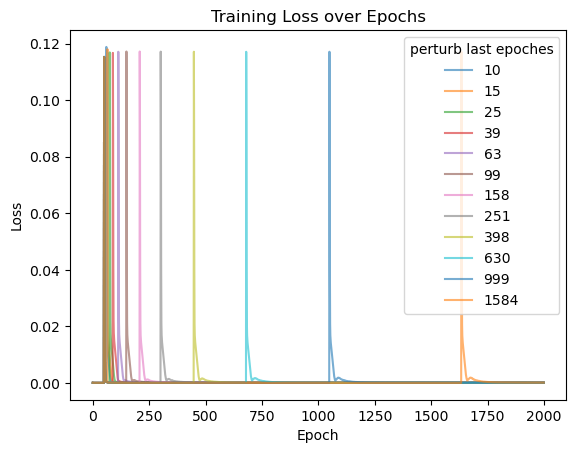

In [48]:
# Plotting the loss
for i, simu_losses in enumerate(all_simu_losses):
    plt.plot(range(simu_epochs), simu_losses, label=perturb_lasts[i], alpha=0.6)
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0,0.02])
# plt.xlim([0,200])
plt.title('Training Loss over Epochs')
plt.legend(title='perturb last epoches')
# plt.savefig('fig/0122_abb05_perturb_loss.png')
plt.show()

In [49]:
recover_costs = []
recover_epochs = []
for k in range(len(all_simu_losses)):
    simu_losses = all_simu_losses[k]
    perturb_last = perturb_lasts[k]
    perturb_start = 50
    origin_start = perturb_start + perturb_last

    recover_cost = 0
    recover_epoch = 0
    for i, loss in enumerate(simu_losses):
        if i > origin_start:
            if loss < 0.0001:
                break
            if loss < 1:
                recover_cost += loss
                recover_epoch += 1

    print(recover_cost)
    print(recover_epoch)
    recover_costs.append(recover_cost)
    recover_epochs.append(recover_epoch)

0.2862243229537853
81
0.2992001620659721
76
0.31937478616600856
92
0.34743643487308873
171
0.37048682705062674
230
0.3761464938215795
203
0.38853872439358383
232
0.3992226521440898
240
0.41222683461091947
265
0.41924828990886454
250
0.42332886981603224
243
0.4248742516065249
239


Text(0.5, 1.0, 'Gain Change over Epochs')

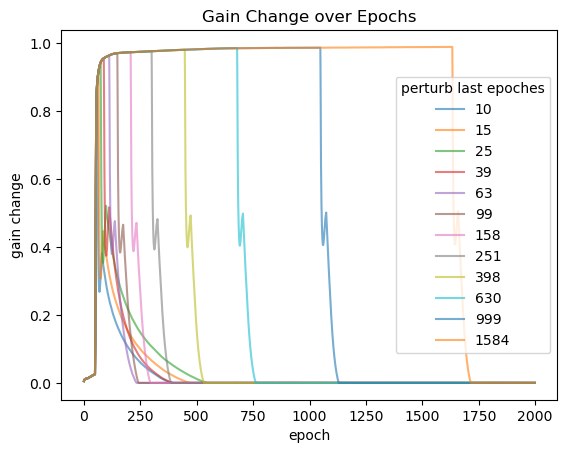

In [50]:
for i, gain_changes in enumerate(all_gain_changes):
    plt.plot(np.arange(simu_epochs), gain_changes, label=perturb_lasts[i], alpha=0.6)
plt.xlabel("epoch")
plt.ylabel("gain change")
plt.legend(title='perturb last epoches')
plt.title('Gain Change over Epochs')
# plt.savefig('fig/0122_abb05_perturb_gc.png')

Text(0.5, 1.0, 'Shift Change over Epochs')

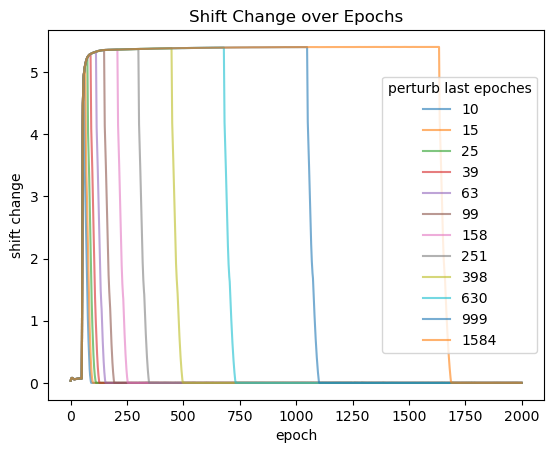

In [51]:
for i, shift_changes in enumerate(all_shift_changes):
    plt.plot(np.arange(simu_epochs), shift_changes, label=perturb_lasts[i], alpha=0.6)
plt.xlabel("epoch")
plt.ylabel("shift change")
plt.legend(title='perturb last epoches')
plt.title('Shift Change over Epochs')
# plt.savefig('fig/0122_abb05_perturb_sc.png')

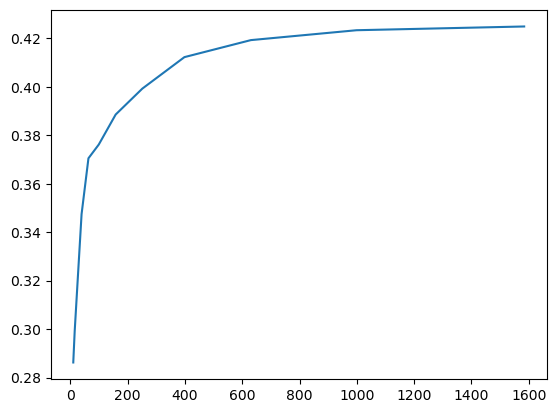

In [52]:
plt.plot(perturb_lasts, recover_costs)

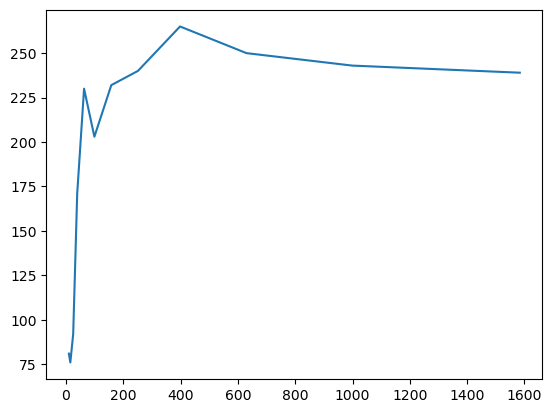

In [53]:
plt.plot(perturb_lasts, recover_epochs)